In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

n_estimators = 400
# A learning rate of 1. may not be optimal for both SAMME and SAMME.R
learning_rate = 1.

X, y = datasets.make_hastie_10_2(n_samples=12000, random_state=1) # 10特征的二分类数据集
X_test, y_test = X[2000:], y[2000:]
X_train, y_train = X[:2000], y[:2000]

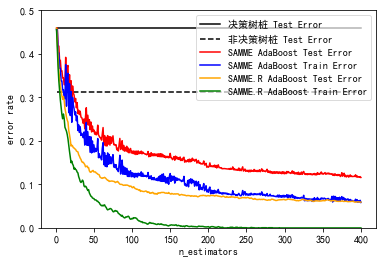

In [2]:
dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
dt.fit(X_train, y_train)
dt_err = 1.0 - dt.score(X_test, y_test)

ada_discrete = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME") # 默认algorithm='SAMME.R'
ada_discrete.fit(X_train, y_train)

ada_real = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    # Discrete SAMME AdaBoost adapts based on errors in predicted class labels whereas real SAMME.R uses the predicted class probabilities.
    algorithm="SAMME.R") # SAMME.R算法通常比SAMME收敛更快(此时base_estimator必须是支持概率预测的分类器),从而以更少的提升迭代次数实现了更低的测试误差
ada_real.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, 'k-',
        label='决策树桩 Test Error')
ax.plot([1, n_estimators], [dt_err] * 2, 'k--',
        label='非决策树桩 Test Error')

ada_discrete_err = np.zeros((n_estimators,))
for i, y_score in enumerate(ada_discrete.staged_score(X_test, y_test)): # 不同数量[1:n_estimators]基本分类器组合时的score(类似函数有staged_predict)
    ada_discrete_err[i] = 1 - y_score

ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_score in enumerate(ada_discrete.staged_score(X_train, y_train)):
    ada_discrete_err_train[i] = 1- y_score

ada_real_err = np.zeros((n_estimators,))
for i, y_score in enumerate(ada_real.staged_score(X_test, y_test)):
    ada_real_err[i] = 1- y_score

ada_real_err_train = np.zeros((n_estimators,))
for i, y_score in enumerate(ada_real.staged_score(X_train, y_train)):
    ada_real_err_train[i] = 1- y_score

ax.plot(np.arange(n_estimators) + 1, ada_discrete_err,
        label='SAMME AdaBoost Test Error',
        color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err_train,
        label='SAMME AdaBoost Train Error',
        color='blue')
ax.plot(np.arange(n_estimators) + 1, ada_real_err,
        label='SAMME.R AdaBoost Test Error',
        color='orange')
ax.plot(np.arange(n_estimators) + 1, ada_real_err_train,
        label='SAMME.R AdaBoost Train Error',
        color='green')

ax.set_ylim((0.0, 0.5))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()
